In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

random_state = 42

In [6]:
def read_dataset(path, sep=';', encoding='utf-8-sig', low_memory=False):
    return pd.read_csv(path, sep=sep, encoding=encoding, low_memory=low_memory)

subjects_bak_spec = read_dataset("../../../../../data/datasets/filtered/subjects_bak_spec_filtered_mahalanobis.csv")
subjects_magistr = read_dataset("../../../../../data/datasets/filtered/subjects_magistr_filtered_mahalanobis.csv")

In [7]:
X_s_bak_spec = subjects_bak_spec.drop(columns=["Таргет"])
y_s_bak_spec = subjects_bak_spec["Таргет"]

X_train_s_bak_spec, X_test_s_bak_spec, y_train_s_bak_spec, y_test_s_bak_spec = train_test_split(
    X_s_bak_spec,
    y_s_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_s_magistr = subjects_magistr.drop(columns=["Таргет"])
y_s_magistr = subjects_magistr["Таргет"]

X_train_s_magistr, X_test_s_magistr, y_train_s_magistr, y_test_s_magistr = train_test_split(
    X_s_magistr,
    y_s_magistr,
    test_size=0.2,
    random_state=random_state
)

{'clf__alpha': 0.0001, 'clf__class_weight': 'balanced', 'clf__penalty': None}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 Perceptron(class_weight='balanced', early_stopping=True,
                            random_state=42))])

Отчёт классификации (дефолтный порог):

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       111
           1       0.46      0.81      0.59        16

    accuracy                           0.86       127
   macro avg       0.72      0.84      0.75       127
weighted avg       0.91      0.86      0.87       127



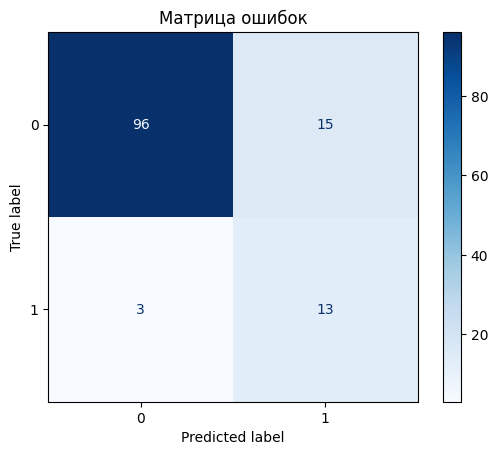


Feature Importances:
                                            feature  importance
37                      Позиция студента в рейтинге    0.412579
36                             Код направления 3: 4    0.059829
12                          Human Development Index    0.030122
31                            Код направления 1: 11    0.029081
10                                 fromEkaterinburg    0.023498
2                           Балл за инд. достижения    0.022926
4                             Нуждается в общежитии    0.022536
35                             Код направления 3: 3    0.013131
6                                               Пол    0.011818
0                                         Приоритет    0.008233
18                                          Заочная    0.007765
7                  Полных лет на момент поступления    0.005195
8                         Общее количество пересдач    0.003158
1                            Cумма баллов испытаний    0.000000
5                 

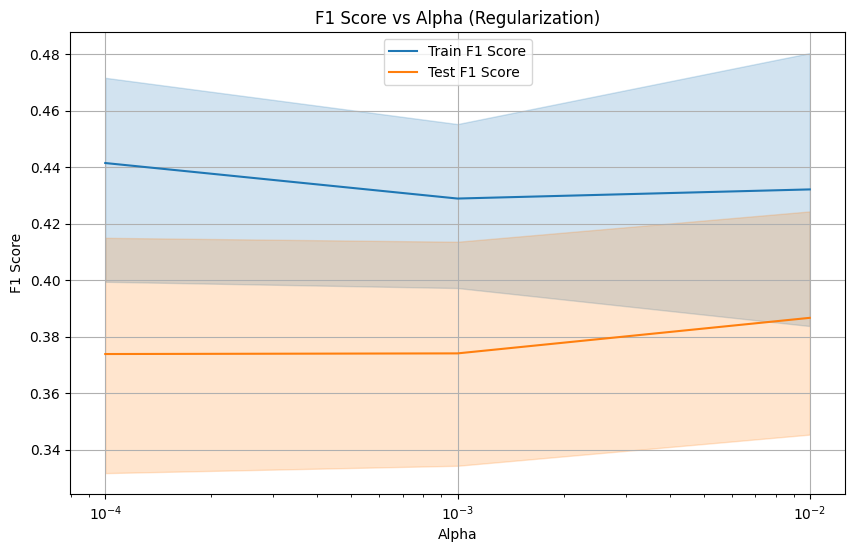

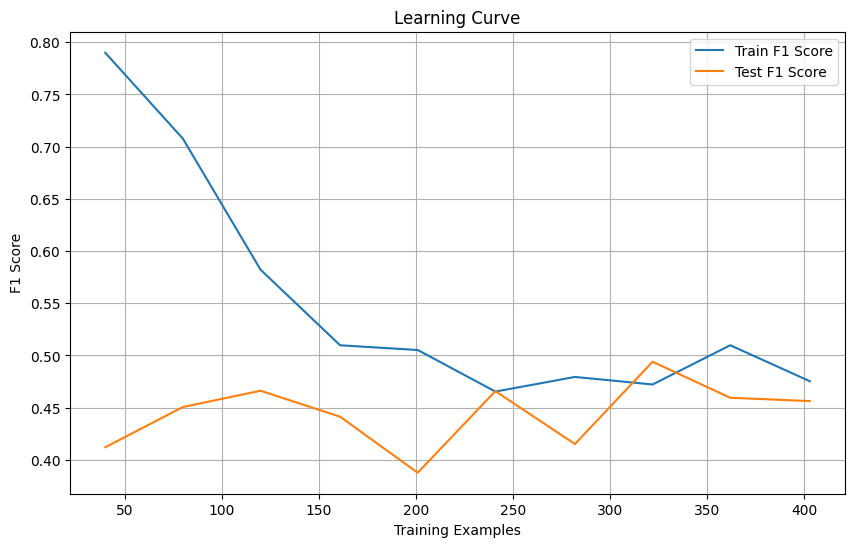

In [8]:
'''-----------------------------------------------------------------------------------------------------
                                        ИМПОРТ НЕОБХОДИМЫХ БИБЛИОТЕК
-----------------------------------------------------------------------------------------------------'''

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.inspection import permutation_importance
import numpy as np
from sklearn.metrics import make_scorer, f1_score

'''-----------------------------------------------------------------------------------------------------
                                            ПОДГОТОВКА ПАЙПЛАЙНА
-----------------------------------------------------------------------------------------------------'''

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', Perceptron(max_iter=1000, random_state=42, early_stopping=True))
])

param_grid = {
    'clf__penalty': [None, 'l1', 'l2'],
    'clf__alpha': [0.0001, 0.001, 0.01],
    'clf__class_weight': [None, 'balanced']
}

custom_scorer = make_scorer(f1_score, pos_label=1)

'''-----------------------------------------------------------------------------------------------------
                                                ОБУЧЕНИЕ МОДЕЛИ
-----------------------------------------------------------------------------------------------------'''

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train_s_magistr, y_train_s_magistr)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../../../../data/models/final/filtered/perceptron_model_s_magistr_mah.joblib')

'''-----------------------------------------------------------------------------------------------------
                                  ВЫВОД ОТЧЁТА КЛАССИФИКАЦИИ С ДЕФОЛТНЫМ ПОРОГОМ
-----------------------------------------------------------------------------------------------------'''

y_pred_s_magistr = best_model.predict(X_test_s_magistr)

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации (дефолтный порог):\n")
print(classification_report(y_test_s_magistr, y_pred_s_magistr))

'''-----------------------------------------------------------------------------------------------------
                                            СОЗДАНИЕ МАТРИЦЫ ОШИБОК
-----------------------------------------------------------------------------------------------------'''

cm = confusion_matrix(y_test_s_magistr, y_pred_s_magistr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig('perceptron/s_magistr/confusion_matrix_perceptron.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                          ВЫВОД ВЛИЯНИЯ ВСЕХ ПРИЗНАКОВ
-----------------------------------------------------------------------------------------------------'''

result = permutation_importance(
    best_model,
    X_test_s_magistr,
    y_test_s_magistr,
    scoring=custom_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
features = X_train_s_magistr.columns

feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

'''-----------------------------------------------------------------------------------------------------
                              ВЫВОД ЗАВИСИМОСТИ F1 ОТ ГИПЕРПАРАМЕТРОВ
-----------------------------------------------------------------------------------------------------'''

results = pd.DataFrame(grid_search.cv_results_)

results_filtered = results[[
    'param_clf__alpha',
    'mean_train_score',
    'mean_test_score'
]].copy()

results_filtered['param_clf__alpha'] = pd.to_numeric(results_filtered['param_clf__alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__alpha', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__alpha', y='mean_test_score', label='Test F1 Score')
plt.xscale('log')
plt.title('F1 Score vs Alpha (Regularization)')
plt.xlabel('Alpha')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('perceptron/s_magistr/f1_vs_alpha_perceptron.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                           ВЫВОД КРИВОЙ ОБУЧЕНИЯ
-----------------------------------------------------------------------------------------------------'''

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_s_magistr,
    y=y_train_s_magistr,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('perceptron/s_magistr/learning_curve_perceptron.png')
plt.show()

{'clf__alpha': 0.0001, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
Лучшая модель: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 Perceptron(class_weight='balanced', early_stopping=True,
                            penalty='l2', random_state=42))])

Отчёт классификации (дефолтный порог):

              precision    recall  f1-score   support

           0       0.93      0.74      0.82       234
           1       0.39      0.77      0.52        52

    accuracy                           0.74       286
   macro avg       0.66      0.75      0.67       286
weighted avg       0.84      0.74      0.77       286



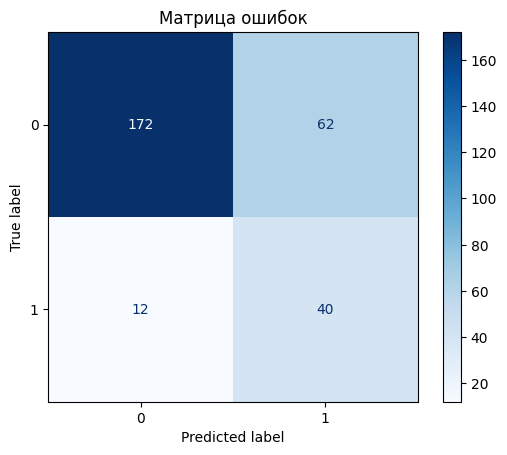


Feature Importances:
                                            feature  importance
39                      Позиция студента в рейтинге    0.252207
19                                          Заочная    0.027019
13                          Human Development Index    0.022091
3                           Балл за инд. достижения    0.019590
33                            Код направления 1: 11    0.016674
34                            Код направления 1: 27    0.010988
35                            Код направления 1: 29    0.010083
38                             Код направления 3: 4    0.009902
9                         Общее количество пересдач    0.007834
5                             Нуждается в общежитии    0.007765
20                                     Очно-заочная    0.006789
8                  Полных лет на момент поступления    0.005117
0                                         Приоритет    0.004473
37                             Код направления 3: 3    0.001826
2                 

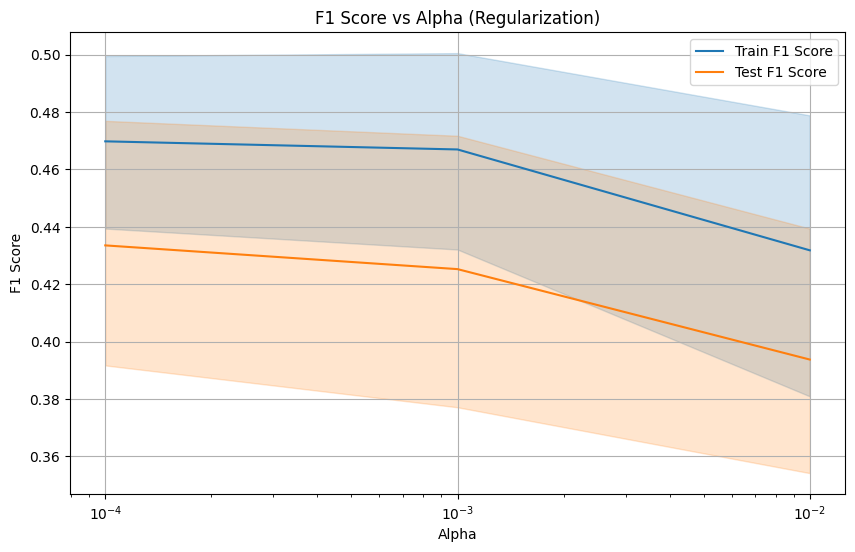

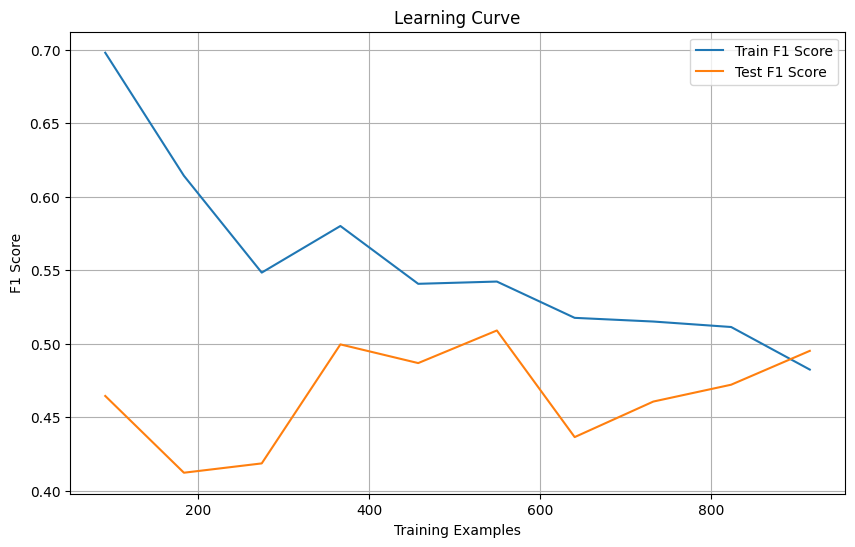

In [9]:
'''-----------------------------------------------------------------------------------------------------
                                        ИМПОРТ НЕОБХОДИМЫХ БИБЛИОТЕК
-----------------------------------------------------------------------------------------------------'''

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.inspection import permutation_importance
import numpy as np
from sklearn.metrics import make_scorer, f1_score

'''-----------------------------------------------------------------------------------------------------
                                            ПОДГОТОВКА ПАЙПЛАЙНА
-----------------------------------------------------------------------------------------------------'''

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', Perceptron(max_iter=1000, random_state=42, early_stopping=True))
])

param_grid = {
    'clf__penalty': [None, 'l1', 'l2'],
    'clf__alpha': [0.0001, 0.001, 0.01],
    'clf__class_weight': [None, 'balanced']
}

custom_scorer = make_scorer(f1_score, pos_label=1)

'''-----------------------------------------------------------------------------------------------------
                                                ОБУЧЕНИЕ МОДЕЛИ
-----------------------------------------------------------------------------------------------------'''

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train_s_bak_spec, y_train_s_bak_spec)

best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../../../../data/models/final/filtered/perceptron_model_s_bak_spec_mah.joblib')

'''-----------------------------------------------------------------------------------------------------
                                  ВЫВОД ОТЧЁТА КЛАССИФИКАЦИИ С ДЕФОЛТНЫМ ПОРОГОМ
-----------------------------------------------------------------------------------------------------'''

y_pred_s_bak_spec = best_model.predict(X_test_s_bak_spec)

print(grid_search.best_params_)
print("Лучшая модель:", grid_search.best_estimator_)
print("\nОтчёт классификации (дефолтный порог):\n")
print(classification_report(y_test_s_bak_spec, y_pred_s_bak_spec))

'''-----------------------------------------------------------------------------------------------------
                                            СОЗДАНИЕ МАТРИЦЫ ОШИБОК
-----------------------------------------------------------------------------------------------------'''

cm = confusion_matrix(y_test_s_bak_spec, y_pred_s_bak_spec)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig('perceptron/s_bak_spec/confusion_matrix_perceptron.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                          ВЫВОД ВЛИЯНИЯ ВСЕХ ПРИЗНАКОВ
-----------------------------------------------------------------------------------------------------'''

result = permutation_importance(
    best_model,
    X_test_s_bak_spec,
    y_test_s_bak_spec,
    scoring=custom_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
features = X_train_s_bak_spec.columns

feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

'''-----------------------------------------------------------------------------------------------------
                              ВЫВОД ЗАВИСИМОСТИ F1 ОТ ГИПЕРПАРАМЕТРОВ
-----------------------------------------------------------------------------------------------------'''

results = pd.DataFrame(grid_search.cv_results_)

results_filtered = results[[
    'param_clf__alpha',
    'mean_train_score',
    'mean_test_score'
]].copy()

results_filtered['param_clf__alpha'] = pd.to_numeric(results_filtered['param_clf__alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__alpha', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__alpha', y='mean_test_score', label='Test F1 Score')
plt.xscale('log')
plt.title('F1 Score vs Alpha (Regularization)')
plt.xlabel('Alpha')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('perceptron/s_bak_spec/f1_vs_alpha_perceptron.png')
plt.show()

'''-----------------------------------------------------------------------------------------------------
                                           ВЫВОД КРИВОЙ ОБУЧЕНИЯ
-----------------------------------------------------------------------------------------------------'''

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_s_bak_spec,
    y=y_train_s_bak_spec,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('perceptron/s_bak_spec/learning_curve_perceptron.png')
plt.show()